In [5]:
from stochastic.processes.diffusion import OrnsteinUhlenbeckProcess
import matplotlib.pyplot as plt
import numpy as np
from web3 import Web3
from decimal import Decimal

In [6]:
def get_arbs(eth_price_path, gas_usage):
    gas_price = Web3.to_wei(40, 'gwei')
    
    secondary_price = eth_price_path[0]
    arb_opps = []
    for i, price in enumerate(eth_price_path):
        gas_paid_usd = price * float(Web3.from_wei(gas_price * gas_usage, 'ether'))

        ask_price = (price*1.0005) + gas_paid_usd
        bid_price = (price*0.9995) - gas_paid_usd

        ask_price_secondary = (secondary_price*1.003)
        bid_price_secondary = (secondary_price*0.997)

        if ask_price < bid_price_secondary:
            secondary_price = price
            arb_opps.append((i, price, secondary_price))
            continue
        if ask_price_secondary < bid_price:
            secondary_price = price
            arb_opps.append((i, price, secondary_price))
    return arb_opps

/var/folders/33/2v5y2s3x3lzfkmb3q2srbws00000gn/T/ipykernel_44304/3382559890.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{t*24:.2f}' for t in ax.get_xticks()])


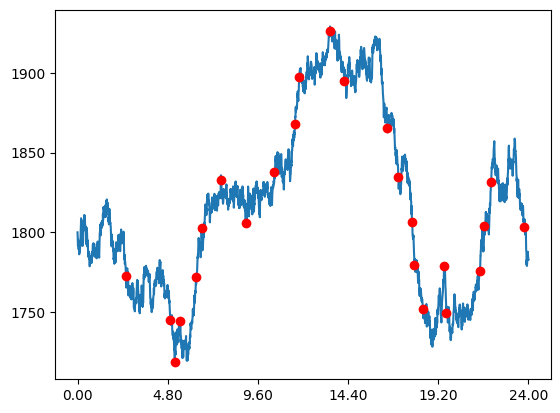

In [7]:
price_path = OrnsteinUhlenbeckProcess(speed=1, vol=.08, t=1)

N_PRICE_SAMPLES = 3000 # based on 14 days of ETHUSDC 5bps v3, 3800 trades per day 
y = price_path.sample(n=N_PRICE_SAMPLES, initial=0)

eth_price_path = (y+1)*1800
x = price_path.times(n=N_PRICE_SAMPLES)

arb_opps = get_arbs(eth_price_path, gas_usage=Decimal(280_000))
arb_x = [x[a[0]] for a in arb_opps]
arb_y = [a[1] for a in arb_opps]

fig, ax = plt.subplots()
ax.plot(x, eth_price_path)
ax.plot(arb_x, arb_y, 'ro')

ax.set_xticklabels([f'{t*24:.2f}' for t in ax.get_xticks()])

plt.show()

/var/folders/33/2v5y2s3x3lzfkmb3q2srbws00000gn/T/ipykernel_44304/1777293554.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0f}'.format(x) for x in ax.get_xticks()])


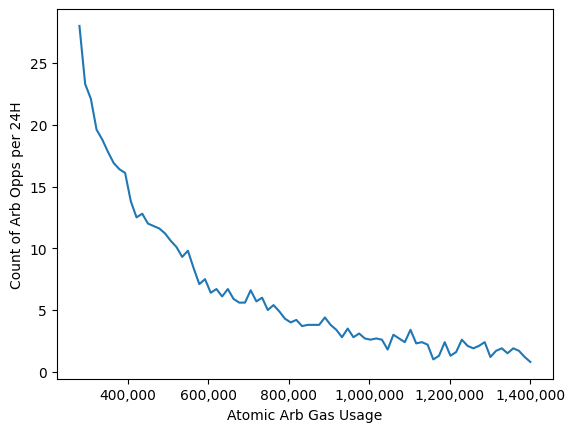

In [8]:
gas_usages = np.linspace(280_000, 1_400_000, 80).astype(int)

SUB_SAMPLES = 10

arb_counts = []
for i in range(gas_usages.shape[0]):
    
    # sample 5 different price paths and count the number of arb opportunities
    arb_sum = 0
    for _ in range(SUB_SAMPLES):
        y = price_path.sample(n=N_PRICE_SAMPLES, initial=0)
        eth_price_path = (y+1)*1800

        arbs = get_arbs(eth_price_path, gas_usage=Decimal(int(gas_usages[i])))
        arb_sum += len(arbs)
    arb_counts.append(arb_sum/SUB_SAMPLES)

fig, ax = plt.subplots()
ax.plot(gas_usages, arb_counts)

ax.set_xlabel('Atomic Arb Gas Usage')
ax.set_ylabel('Count of Arb Opps per 24H')

ax.set_xticklabels(['{:,.0f}'.format(x) for x in ax.get_xticks()])

plt.show()
    